<a href="https://colab.research.google.com/github/CarFer95/ProyectoCancelacionesPedido/blob/dev/ProyectoCancelaciones_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importaciones
import warnings, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 120)

# Comprobar archivos (dataset), estan en la misma ubicacion de este archivo
files_needed = [
    "olist_orders_dataset.csv",
    "olist_order_items_dataset.csv",
    "olist_order_payments_dataset.csv",
    "olist_customers_dataset.csv",
    "olist_sellers_dataset.csv",
    "olist_products_dataset.csv",
    "product_category_name_translation.csv"  # dataset opcional
]
print("Dataset presentes:", [f for f in files_needed if os.path.exists(f)])

In [ ]:
#Importaciones
import warnings, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 120)


BASE = "/content/drive/MyDrive/MAESTRIA/MODULO_XIII/prueba00/"

files_needed = {
    "orders": os.path.join(BASE, "olist_orders_dataset.csv"),
    "order_items": os.path.join(BASE, "olist_order_items_dataset.csv"),
    "payments": os.path.join(BASE, "olist_order_payments_dataset.csv"),
    "reviews": os.path.join(BASE, "olist_order_reviews_dataset.csv"),
    "customers": os.path.join(BASE, "olist_customers_dataset.csv"),
    "sellers": os.path.join(BASE, "olist_sellers_dataset.csv"),
    "products": os.path.join(BASE, "olist_products_dataset.csv"),
    "geolocation": os.path.join(BASE, "olist_geolocation_dataset.csv"),
    "category_trans": os.path.join(BASE, "product_category_name_translation.csv"),
}


In [ ]:
# Cargar dataset
parse_cols = [
    "order_purchase_timestamp","order_approved_at",
    "order_delivered_carrier_date","order_delivered_customer_date",
    "order_estimated_delivery_date"
]
orders         = pd.read_csv(files_needed["orders"], parse_dates=parse_cols)
order_items    = pd.read_csv(files_needed["order_items"])
order_payments = pd.read_csv(files_needed["payments"])
customers      = pd.read_csv(files_needed["customers"])
sellers        = pd.read_csv(files_needed["sellers"])
products       = pd.read_csv(files_needed["products"])

# archivo opcional
try:
    cat_trad = pd.read_csv(files_needed["category_trans"])
except FileNotFoundError:
    cat_trad = None

print(orders.shape, order_items.shape, order_payments.shape, customers.shape, sellers.shape, products.shape)

(99441, 8) (112650, 7) (103886, 5) (99441, 5) (3095, 4) (32951, 9)


In [ ]:
# Crear target y columnas temporales
df = orders.copy()
df["is_canceled"] = (df["order_status"] == "canceled").astype(int)
df["purchase_ym"] = df["order_purchase_timestamp"].dt.to_period("M").astype(str)

print(df["order_status"].value_counts(dropna=False))
print("\nTasa global de cancelación:", df["is_canceled"].mean().round(4))

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

Tasa global de cancelación: 0.0063


In [ ]:
# Agregados de items a nivel order_id
items_agg = (order_items
             .groupby("order_id")
             .agg(price_sum=("price","sum"),
                  freight_sum=("freight_value","sum"),
                  items_qty=("order_item_id","count"),
                  seller_count=("seller_id", pd.Series.nunique))
             .reset_index())

# Categoría principal del pedido (moda entre productos del pedido)
items_cat = (order_items
             .merge(products[["product_id","product_category_name"]], on="product_id", how="left")
             .groupby("order_id")["product_category_name"]
             .agg(lambda s: s.mode().iat[0] if not s.mode().empty else np.nan)
             .reset_index()
             .rename(columns={"product_category_name":"main_category"}))

# Traducción opcional de categorías
if cat_trad is not None and {"product_category_name","product_category_name_english"}.issubset(cat_trad.columns):
    items_cat = items_cat.merge(
        cat_trad.rename(columns={
            "product_category_name":"main_category",
            "product_category_name_english":"main_category_en"
        }),
        on="main_category", how="left"
    )

items_agg.head()

,order_id,price_sum,freight_sum,items_qty,seller_count
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29,1,1
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93,1,1
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87,1,1
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79,1,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14,1,1


In [ ]:
# Agregados de pagos a nivel order_id
def moda_safe(s):
    m = s.mode()
    return m.iat[0] if len(m) else np.nan

pay_agg = (order_payments
           .groupby("order_id")
           .agg(payment_value_sum=("payment_value","sum"),
                max_installments=("payment_installments","max"),
                payments_cnt=("payment_type","count"),
                main_payment_type=("payment_type", moda_safe))
           .reset_index())

pay_agg.head()

,order_id,payment_value_sum,max_installments,payments_cnt,main_payment_type
0,00010242fe8c5a6d1ba2dd792cb16214,72.19,2,1,credit_card
1,00018f77f2f0320c557190d7a144bdd3,259.83,3,1,credit_card
2,000229ec398224ef6ca0657da4fc703e,216.87,5,1,credit_card
3,00024acbcdf0a6daa1e931b038114c75,25.78,2,1,credit_card
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04,3,1,credit_card


In [ ]:
# Ubicación de cliente y vendedor principal
# Cliente (join directo con customers)
cust_keep = ["customer_id","customer_city","customer_state","customer_zip_code_prefix"]
df = df.merge(customers[cust_keep], on="customer_id", how="left")

# Vendedor principal por pedido (moda de estado/ciudad)
seller_state_by_order = (order_items[["order_id","seller_id"]]
                         .merge(sellers[["seller_id","seller_city","seller_state"]], on="seller_id", how="left")
                         .groupby("order_id")[["seller_city","seller_state"]]
                         .agg(lambda s: moda_safe(s))
                         .reset_index()
                         .rename(columns={"seller_city":"main_seller_city","seller_state":"main_seller_state"}))

# Unir todo al nivel de pedido
df = (df
      .merge(items_agg, on="order_id", how="left")
      .merge(items_cat, on="order_id", how="left")
      .merge(pay_agg, on="order_id", how="left")
      .merge(seller_state_by_order, on="order_id", how="left"))

df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,is_canceled,purchase_ym,customer_city,customer_state,customer_zip_code_prefix,price_sum,freight_sum,items_qty,seller_count,main_category,main_category_en,payment_value_sum,max_installments,payments_cnt,main_payment_type,main_seller_city,main_seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,0,2017-10,sao paulo,SP,3149,29.99,8.72,1.0,1.0,utilidades_domesticas,housewares,38.71,1.0,3.0,voucher,maua,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,0,2018-07,barreiras,BA,47813,118.70,22.76,1.0,1.0,perfumaria,perfumery,141.46,1.0,1.0,boleto,belo horizonte,SP
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,0,2018-08,vianopolis,GO,75265,159.90,19.22,1.0,1.0,automotivo,auto,179.12,3.0,1.0,credit_card,guariba,SP
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,0,2017-11,sao goncalo do amarante,RN,59296,45.00,27.20,1.0,1.0,pet_shop,pet_shop,72.20,1.0,1.0,credit_card,belo horizonte,MG
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,0,2018-02,santo andre,SP,9195,19.90,8.72,1.0,1.0,papelaria,stationery,28.62,1.0,1.0,credit_card,mogi das cruzes,SP


In [ ]:
# Limpieza mínima y features
for col in ["price_sum","freight_sum","items_qty","seller_count",
            "payment_value_sum","max_installments","payments_cnt"]:
    df[col] = df[col].fillna(0)

df["order_total_value"] = df["price_sum"] + df["freight_sum"]

print(df[["is_canceled","order_total_value","price_sum","freight_sum","items_qty","seller_count",
          "payment_value_sum","max_installments","payments_cnt"]].describe().T)

                     count        mean         std  min    25%     50%  \
is_canceled        99441.0    0.006285    0.079030  0.0   0.00    0.00   
order_total_value  99441.0  159.326166  220.058804  0.0  61.05  104.56   
price_sum          99441.0  136.680481  210.172081  0.0  45.00   85.00   
freight_sum        99441.0   22.645685   21.659564  0.0  13.72   17.09   
items_qty          99441.0    1.132833    0.545666  0.0   1.00    1.00   
seller_count       99441.0    1.005722    0.150947  0.0   1.00    1.00   
payment_value_sum  99441.0  160.988648  221.950728  0.0  62.01  105.29   
max_installments   99441.0    2.930491    2.715687  0.0   1.00    2.00   
payments_cnt       99441.0    1.044700    0.381178  0.0   1.00    1.00   

                      75%       max  
is_canceled          0.00      1.00  
order_total_value  176.00  13664.08  
price_sum          149.90  13440.00  
freight_sum         23.92   1794.96  
items_qty            1.00     21.00  
seller_count         1.00      

Tasa de cancelación: 0.0063

Cancelación por método de pago:
main_payment_type
not_defined    1.0000
voucher        0.0401
credit_card    0.0058
boleto         0.0048
debit_card     0.0046
Name: is_canceled, dtype: float64

Cancelación por rango de cuotas:
installments_bin
0       0.0000
1       0.0067
2-3     0.0057
4-6     0.0058
7-12    0.0065
13+     0.0054
Name: is_canceled, dtype: float64

Top 10 UFs cliente por tasa de cancelación:
customer_state
RR    0.0217
RO    0.0119
PI    0.0081
SP    0.0078
RJ    0.0067
GO    0.0064
MG    0.0055
MA    0.0054
CE    0.0052
SC    0.0052
Name: is_canceled, dtype: float64


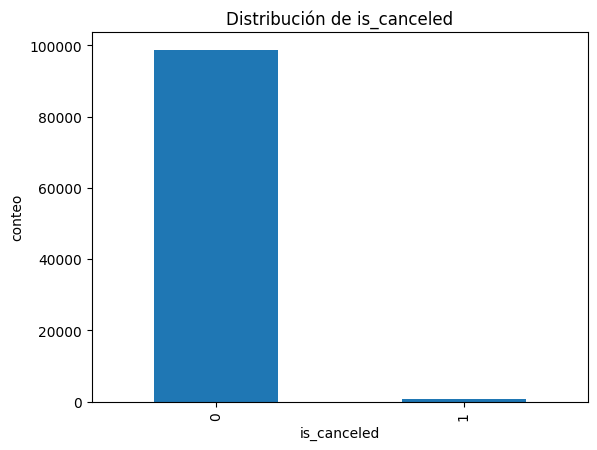

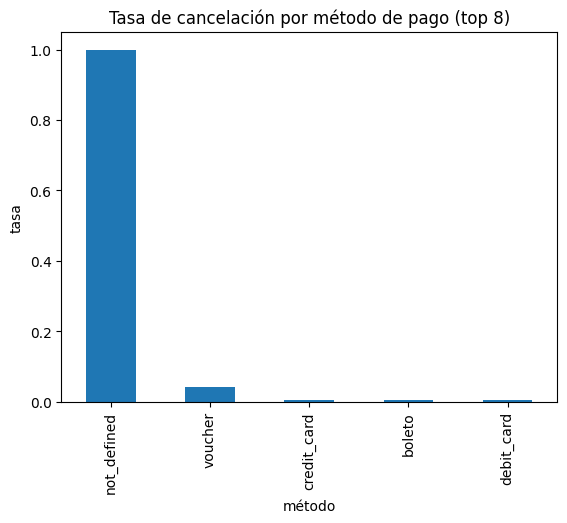

In [ ]:
# EDA
print("Tasa de cancelación:", df["is_canceled"].mean().round(4))

print("\nCancelación por método de pago:")
print(df.groupby("main_payment_type")["is_canceled"].mean().sort_values(ascending=False).round(4))

# bins de cuotas
bins = [-1,0,1,3,6,12,100]
labels = ["0","1","2-3","4-6","7-12","13+"]
df["installments_bin"] = pd.cut(df["max_installments"], bins=bins, labels=labels)

print("\nCancelación por rango de cuotas:")
print(df.groupby("installments_bin")["is_canceled"].mean().round(4))

print("\nTop 10 UFs cliente por tasa de cancelación:")
print(df.groupby("customer_state")["is_canceled"].mean().sort_values(ascending=False).round(4).head(10))

# Gráfico 1: distribución del target
fig, ax = plt.subplots()
df["is_canceled"].value_counts().sort_index().plot(kind="bar", ax=ax)
ax.set_title("Distribución de is_canceled")
ax.set_xlabel("is_canceled"); ax.set_ylabel("conteo")
plt.show()

# Gráfico 2: tasa por método de pago (top 8)
fig, ax = plt.subplots()
(df.groupby("main_payment_type")["is_canceled"].mean()
   .sort_values(ascending=False).head(8)).plot(kind="bar", ax=ax)
ax.set_title("Tasa de cancelación por método de pago (top 8)")
ax.set_ylabel("tasa"); ax.set_xlabel("método")
plt.show()



In [ ]:
# Selección de columnas para modelado
feature_cols = [
    "order_total_value","price_sum","freight_sum","items_qty","seller_count",
    "payment_value_sum","max_installments","payments_cnt","main_payment_type",
    "customer_state","customer_city","main_seller_state",
    "main_category"  # o "main_category_en" si se tradujo
]
meta_cols   = ["order_id","order_purchase_timestamp","purchase_ym"]
target_col  = ["is_canceled"]

df_ml = df[meta_cols + feature_cols + target_col].copy()
print("Shape df_ml:", df_ml.shape)
df_ml.head()

Shape df_ml: (99441, 17)


,order_id,order_purchase_timestamp,purchase_ym,order_total_value,price_sum,freight_sum,items_qty,seller_count,payment_value_sum,max_installments,payments_cnt,main_payment_type,customer_state,customer_city,main_seller_state,main_category,is_canceled
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10,38.71,29.99,8.72,1.0,1.0,38.71,1.0,3.0,voucher,SP,sao paulo,SP,utilidades_domesticas,0
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-07,141.46,118.70,22.76,1.0,1.0,141.46,1.0,1.0,boleto,BA,barreiras,SP,perfumaria,0
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08,179.12,159.90,19.22,1.0,1.0,179.12,3.0,1.0,credit_card,GO,vianopolis,SP,automotivo,0
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-11,72.20,45.00,27.20,1.0,1.0,72.20,1.0,1.0,credit_card,RN,sao goncalo do amarante,MG,pet_shop,0
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2018-02,28.62,19.90,8.72,1.0,1.0,28.62,1.0,1.0,credit_card,SP,santo andre,SP,papelaria,0


In [ ]:
# Dummies simples
cat_cols = ["main_payment_type","customer_state","customer_city","main_seller_state","main_category"]
cat_cols = [c for c in cat_cols if c in df_ml.columns]  # por si no tienes traducción
df_enc = pd.get_dummies(df_ml, columns=cat_cols, dummy_na=True)
print("dummies:", df_enc.shape)

dummies: (99441, 4264)


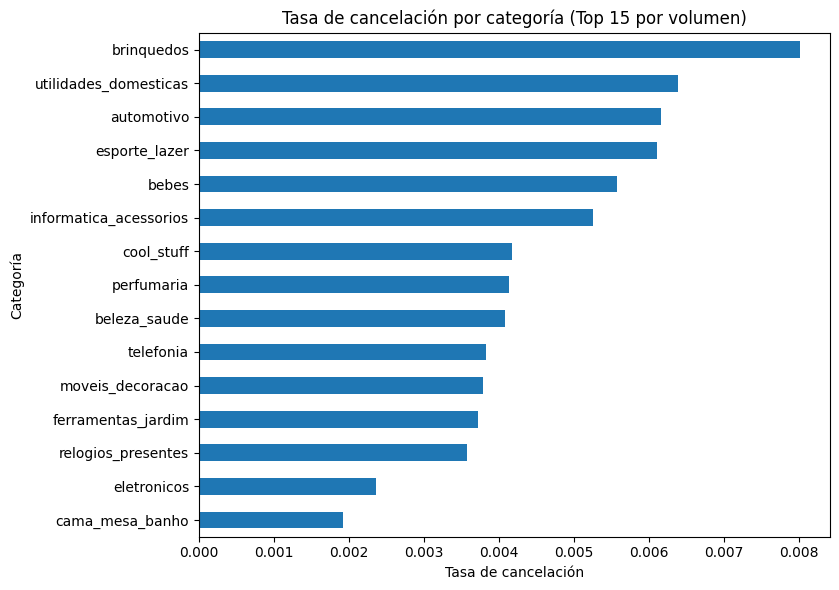

In [ ]:
# 1) Elegir columna de categoría disponible
cat_col = "main_category_en" if "main_category_en" in df_ml.columns else "main_category"

# 2) Filtrar categorías válidas (opcional: excluir 'not_defined')
df_cat = df_ml[df_ml[cat_col].notna()].copy()
df_cat = df_cat[df_cat[cat_col].str.lower() != "not_defined"]

# 3) Top 15 categorías por volumen de pedidos
top15 = (df_cat.groupby(cat_col).size()
         .sort_values(ascending=False)
         .head(15)
         .index)

# 4) Tasa de cancelación por categoría (solo top 15)
rates = (df_cat[df_cat[cat_col].isin(top15)]
         .groupby(cat_col)["is_canceled"]
         .mean()
         .sort_values(ascending=True))

# 5) Plot horizontal
plt.figure(figsize=(8.5, 6))
rates.plot(kind="barh")
plt.xlabel("Tasa de cancelación")
plt.ylabel("Categoría")
plt.title("Tasa de cancelación por categoría (Top 15 por volumen)")
plt.tight_layout()
plt.show()


In [ ]:
# Guardar CSV finales
df_ml.to_csv("orders_joined_for_eda.csv", index=False, encoding="utf-8")
df_enc.to_csv("orders_for_model_baseline.csv", index=False, encoding="utf-8")

print("✓ Guardados:")

KeyError: 'Column not found: time_to_approve_h'

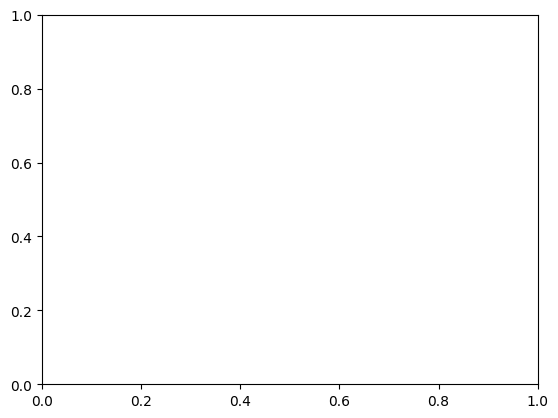

In [ ]:
import matplotlib.pyplot as plt

df.boxplot(column='time_to_approve_h', by='order_status', grid=False)
plt.title('Tiempo hasta aprobación vs Estado del pedido')
plt.suptitle('')
plt.xlabel('Estado del pedido')
plt.ylabel('Horas hasta aprobación')
plt.xticks(rotation=45)
plt.show()

# Promedio por estado
print(df.groupby('order_status')['time_to_approve_h'].mean())


In [ ]:
sns.histplot(data=df, x='freight_per_price', hue='order_status', kde=True, bins=30)
plt.title('Distribución de flete/precio según estado del pedido')
plt.xlabel('Proporción flete/precio')
plt.ylabel('Frecuencia')
plt.show()


NameError: name 'sns' is not defined